In [2]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

In [3]:
db = '/g/data/e14/rmh561/access-om2/archive/databases/cc_database_nostress.db'
session = cc.database.create_session(db)
expt = ['025deg_jra55_ryf_nostress_cont','025deg_jra55_ryf_nostress']
names = {'025deg_jra55_ryf_nostress_cont':'Control','025deg_jra55_ryf_nostress':'No Stress'}

In [49]:
vars_025deg = cc.querying.get_variables(session, experiment=expt[0])
vars_025deg[vars_025deg['name'].str.lower().str.match('')]

,name,long_name,frequency,ncfile,# ncfiles,time_start,time_end
89,vsurf,j-surface current,1 daily,output007/ocean/ocean-2d-vsurf-1-daily-mean-ym...,2,1914-01-01 00:00:00,1916-01-01 00:00:00
90,vvel,ice velocity (y),1 daily,output009/ice/OUTPUT/iceh.1919-12-31.nc,7300,1900-01-01 00:00:00,1920-01-01 00:00:00
263,v,j-current,1 monthly,output009/ocean/ocean-3d-v-1-monthly-mean-ym_1...,40,1900-01-01 00:00:00,1920-01-01 00:00:00
264,vatm_m,atm velocity (y),1 monthly,output009/ice/OUTPUT/iceh.1919-12.nc,240,1900-01-01 00:00:00,1920-01-01 00:00:00
265,vert_pv,vertical piece of Ertel PV: (f+zeta)*N^2,1 monthly,output009/ocean/ocean-3d-vert_pv-1-monthly-mea...,20,1900-01-01 00:00:00,1920-01-01 00:00:00
266,vicen_m,"ice volume, categories",1 monthly,output009/ice/OUTPUT/iceh.1919-12.nc,240,1900-01-01 00:00:00,1920-01-01 00:00:00
267,vvel_m,ice velocity (y),1 monthly,output009/ice/OUTPUT/iceh.1919-12.nc,240,1900-01-01 00:00:00,1920-01-01 00:00:00


In [4]:
start_time = '1910-01-01'
end_time = '1911-12-31'
u_con = cc.querying.getvar(expt[0],'u',session,frequency = '1 monthly',start_time='1910-01-01', ncfile ='ocean-3d-u-1-monthly-mean-ym_%.nc',
                       end_time='1911-12-31').sel(xu_ocean = slice(-90,10)).sel(yu_ocean = slice(10,65))
v_con = cc.querying.getvar(expt[0],'v',session,frequency = '1 monthly',start_time='1910-01-01', ncfile ='ocean-3d-v-1-monthly-mean-ym_%.nc',
                       end_time='1911-12-31').sel(xu_ocean = slice(-90,10)).sel(yu_ocean = slice(10,65))
u_buo = cc.querying.getvar(expt[1],'u',session,frequency = '1 monthly',start_time='1910-01-01', ncfile ='ocean-3d-u-1-monthly-mean-ym_%.nc',
                       end_time='1911-12-31').sel(xu_ocean = slice(-90,10)).sel(yu_ocean = slice(10,65))
v_buo = cc.querying.getvar(expt[1],'v',session,frequency = '1 monthly',start_time='1910-01-01', ncfile ='ocean-3d-v-1-monthly-mean-ym_%.nc',
                       end_time='1911-12-31').sel(xu_ocean = slice(-90,10)).sel(yu_ocean = slice(10,65))
u_con = u_con.sel(time = slice(start_time,end_time))
v_con = v_con.sel(time = slice(start_time,end_time))
u_buo = u_buo.sel(time = slice(start_time,end_time))
v_buo = v_buo.sel(time = slice(start_time,end_time))

## Weddell Gyre Analysis - Transport

In [25]:
tx_trans_int_z_con = cc.querying.getvar(expt[0],'tx_trans_int_z',session,start_time='1900-01-01', 
                       end_time='1920-12-31').sel(xu_ocean = slice(-80,40)).sel(yt_ocean = slice(-80,-50))
ty_trans_int_z_con = cc.querying.getvar(expt[0],'ty_trans_int_z',session,start_time='1900-01-01', 
                       end_time='1920-12-31').sel(xt_ocean = slice(-80,40)).sel(yu_ocean = slice(-80,-50))
tx_trans_int_z_buo = cc.querying.getvar(expt[1],'tx_trans_int_z',session,start_time='1900-01-01', 
                       end_time='1920-12-31').sel(xu_ocean = slice(-80,40)).sel(yt_ocean = slice(-80,-50))
ty_trans_int_z_buo = cc.querying.getvar(expt[1],'ty_trans_int_z',session,start_time='1900-01-01', 
                       end_time='1920-12-31').sel(xt_ocean = slice(-80,40)).sel(yu_ocean = slice(-80,-50))
T_surf_con = cc.querying.getvar(expt[0],'temp_surface_ave',session,start_time='1900-01-01', 
                       end_time='1920-12-31')
T_surf_buo = cc.querying.getvar(expt[1],'temp_surface_ave',session,start_time='1900-01-01', 
                       end_time='1920-12-31')

In [43]:
MLD_con = cc.querying.getvar(expt[0],'mld',session,frequency = '1 monthly',start_time='1900-01-01', 
                       end_time='1920-12-31').sel(xt_ocean = slice(-80,40)).sel(yt_ocean = slice(-80,-50))
MLD_buo = cc.querying.getvar(expt[1],'mld',session,frequency = '1 monthly',start_time='1900-01-01', 
                       end_time='1920-12-31').sel(xt_ocean = slice(-80,40)).sel(yt_ocean = slice(-80,-50))
HBLT_con = cc.querying.getvar(expt[0],'hblt',session,frequency = '1 monthly',start_time='1900-01-01', 
                       end_time='1920-12-31').sel(xt_ocean = slice(-80,40)).sel(yt_ocean = slice(-80,-50))
HBLT_buo = cc.querying.getvar(expt[1],'hblt',session,frequency = '1 monthly',start_time='1900-01-01', 
                       end_time='1920-12-31').sel(xt_ocean = slice(-80,40)).sel(yt_ocean = slice(-80,-50))

In [31]:
Qnet_con = cc.querying.getvar(expt[0],'net_sfc_heating',session,start_time='1900-01-01',end_time='1920-12-31', n=1).sel(
    xt_ocean = slice(-80,40)).sel(yt_ocean = slice(-80,-50)) + cc.querying.getvar(expt[0],'frazil_3d_int_z',session,start_time='1900-01-01',end_time='1920-12-31', n=1).sel(
    xt_ocean = slice(-80,40)).sel(yt_ocean = slice(-80,-50))
Qnet_buo = cc.querying.getvar(expt[1],'net_sfc_heating',session,start_time='1900-01-01',end_time='1920-12-31', n=1).sel(
    xt_ocean = slice(-80,40)).sel(yt_ocean = slice(-80,-50)) + cc.querying.getvar(expt[],'frazil_3d_int_z',session,start_time='1900-01-01',end_time='1920-12-31', n=1).sel(
    xt_ocean = slice(-80,40)).sel(yt_ocean = slice(-80,-50))

In [50]:
u_con = cc.querying.getvar(expt[0],'u',session,frequency = '1 monthly',start_time='1900-01-01', ncfile ='ocean-3d-u-1-monthly-mean-ym_%.nc',
                       end_time='1920-12-31').sel(xu_ocean = slice(-80,40)).sel(yu_ocean = slice(-80,-50))
v_con = cc.querying.getvar(expt[0],'v',session,frequency = '1 monthly',start_time='1910-01-01', ncfile ='ocean-3d-v-1-monthly-mean-ym_%.nc',
                       end_time='1920-12-31').sel(xu_ocean = slice(-80,40)).sel(yu_ocean = slice(-80,-50))
u_buo = cc.querying.getvar(expt[1],'u',session,frequency = '1 monthly',start_time='1910-01-01', ncfile ='ocean-3d-u-1-monthly-mean-ym_%.nc',
                       end_time='1920-12-31').sel(xu_ocean = slice(-80,40)).sel(yu_ocean = slice(-80,-50))
v_buo = cc.querying.getvar(expt[1],'v',session,frequency = '1 monthly',start_time='1910-01-01', ncfile ='ocean-3d-v-1-monthly-mean-ym_%.nc',
                       end_time='1920-12-31').sel(xu_ocean = slice(-80,40)).sel(yu_ocean = slice(-80,-50))

In [53]:
mu = 0.0014
tau_x_con = mu*u_con.differentiate('st_ocean').sel(st_ocean = 1,method = 'nearest')
tau_y_con = mu*v_con.differentiate('st_ocean').sel(st_ocean = 1,method = 'nearest')
tau_x_buo = mu*u_buo.differentiate('st_ocean').sel(st_ocean = 1,method = 'nearest')
tau_y_buo = mu*v_buo.differentiate('st_ocean').sel(st_ocean = 1,method = 'nearest')

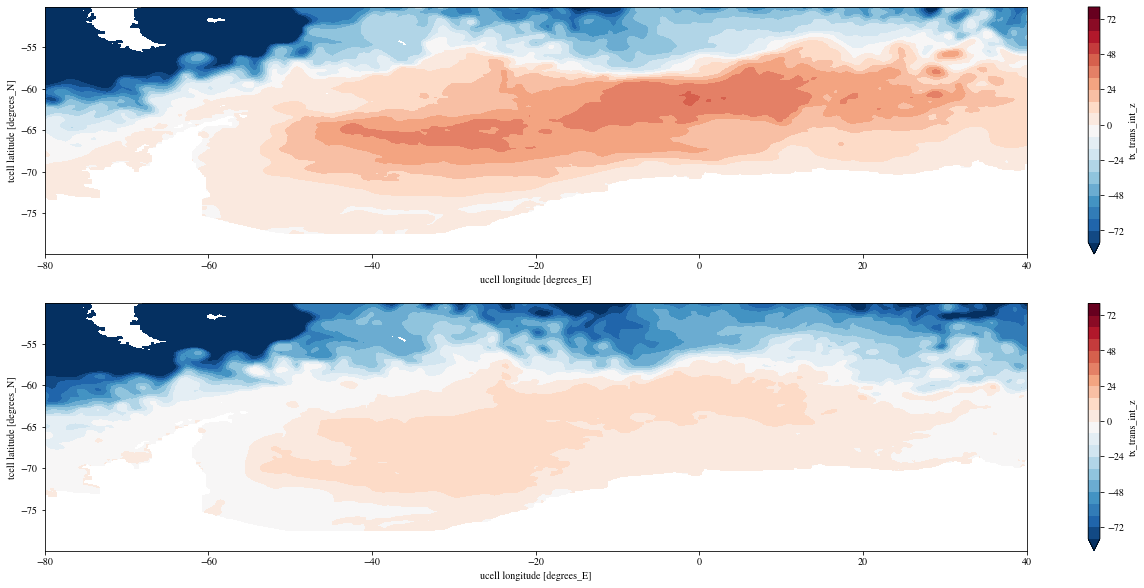

In [45]:
rho0=1035
psi_con = -tx_trans_int_z_con.cumsum('yt_ocean').where(abs(tx_trans_int_z_con<=1.e20))/(rho0*1.e6)
psi_buo = -tx_trans_int_z_buo.cumsum('yt_ocean').where(abs(tx_trans_int_z_buo<=1.e20))/(rho0*1.e6)

plt.figure(figsize=(22,10))

plt.subplot(211)
plt.title('Barotropic Streamfunction for Control Run')
psi_con.sel(time = slice('1905-01-01','1905-01-31')).mean('time').plot.contourf(levels = np.linspace(-80,80,21))

plt.subplot(212)
plt.title('Barotropic Streamfunction for No-Stress Run')
psi_buo.sel(time = slice('1905-01-01','1905-01-31')).mean('time').plot.contourf(levels = np.linspace(-80,80,21))
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=5,ncols=2,figsize=(20,25))

psi_con.sel(xu_ocean = -30, method = 'nearest').sel(yt_ocean = -66, method = 'nearest').plot(ax=axes[0][0],label='Control Run')
psi_buo.sel(xu_ocean = -30, method = 'nearest').sel(yt_ocean = -66, method = 'nearest').plot(ax=axes[0][0],label='No-Stress Run')

psi_con.sel(xu_ocean = -75, method = 'nearest').sel(yt_ocean = -55, method = 'nearest').plot(ax=axes[0][1],label='Control Run')
psi_buo.sel(xu_ocean = -75, method = 'nearest').sel(yt_ocean = -55, method = 'nearest').plot(ax=axes[0][1],label='No-Stress Run')

MLD_con.sel(xt_ocean = -30, method = 'nearest').sel(yt_ocean = -66, method = 'nearest').plot(ax=axes[1][0],label='Control Run')
MLD_buo.sel(xt_ocean = -30, method = 'nearest').sel(yt_ocean = -66, method = 'nearest').plot(ax=axes[1][0],label='No-Stress Run')

MLD_con.sel(xt_ocean = -75, method = 'nearest').sel(yt_ocean = -55, method = 'nearest').plot(ax=axes[1][1],label='Control Run')
MLD_buo.sel(xt_ocean = -75, method = 'nearest').sel(yt_ocean = -55, method = 'nearest').plot(ax=axes[1][1],label='No-Stress Run')

HBLT_con.sel(xt_ocean = -30, method = 'nearest').sel(yt_ocean = -66, method = 'nearest').plot(ax=axes[2][0],label='Control Run')
HBLT_buo.sel(xt_ocean = -30, method = 'nearest').sel(yt_ocean = -66, method = 'nearest').plot(ax=axes[2][0],label='No-Stress Run')

HBLT_con.sel(xt_ocean = -75, method = 'nearest').sel(yt_ocean = -55, method = 'nearest').plot(ax=axes[2][1],label='Control Run')
HBLT_buo.sel(xt_ocean = -75, method = 'nearest').sel(yt_ocean = -55, method = 'nearest').plot(ax=axes[2][1],label='No-Stress Run')

Qnet_con.sel(xt_ocean = -30, method = 'nearest').sel(yt_ocean = -66, method = 'nearest').plot(ax=axes[3][0],label='Control Run')
Qnet_buo.sel(xt_ocean = -30, method = 'nearest').sel(yt_ocean = -66, method = 'nearest').plot(ax=axes[3][0],label='No-Stress Run')

Qnet_con.sel(xt_ocean = -75, method = 'nearest').sel(yt_ocean = -55, method = 'nearest').plot(ax=axes[3][1],label='Control Run')
Qnet_buo.sel(xt_ocean = -75, method = 'nearest').sel(yt_ocean = -55, method = 'nearest').plot(ax=axes[3][1],label='No-Stress Run')

tau_x_con.sel(xu_ocean = -30, method = 'nearest').sel(yt_ocean = -66, method = 'nearest').plot(ax=axes[4][0],label='Control Run')
tau_x_buo.sel(xu_ocean = -30, method = 'nearest').sel(yt_ocean = -66, method = 'nearest').plot(ax=axes[4][0],label='No-Stress Run')

tau_y_con.sel(xu_ocean = -75, method = 'nearest').sel(yu_ocean = -55, method = 'nearest').plot(ax=axes[4][1],label='Control Run')
tau_y_buo.sel(xu_ocean = -75, method = 'nearest').sel(yu_ocean = -55, method = 'nearest').plot(ax=axes[4][1],label='No-Stress Run')

axes[0][0].set_title('Barotropic Streamfunction at (-30,-66) -> Centre of the gyre')
axes[0][1].set_title('Barotropic Streamfunction at (-75,-55) -> Drake Passage Transport')
axes[1][0].set_title('Mixed Layer Depth at (-30,-66)')
axes[1][1].set_title('Mixed Layer Depth at (-75,-55)')
axes[2][0].set_title('Depth from KPP at (-30,-66)')
axes[2][1].set_title('Depth from KPP at (-75,-55)')
axes[2][0].set_title('Heat Flux at (-30,-66)')
axes[2][1].set_title('Heat Flux at (-75,-55)')


axes[0][0].legend()
axes[0][1].legend()
axes[1][0].legend()
axes[1][1].legend()
axes[2][0].legend()
axes[2][1].legend()
axes[3][0].legend()
axes[3][1].legend()

In [38]:
tau_x = cc.querying.getvar(expt[0],'tau_x',session,start_time='1900-01-01', 
                       end_time='1920-12-31').sel(xu_ocean = slice(-80,40)).sel(yu_ocean = slice(-80,-55))
tau_y = cc.querying.getvar(expt[0],'tau_y',session,start_time='1900-01-01', 
                       end_time='1920-12-31').sel(xu_ocean = slice(-80,40)).sel(yu_ocean = slice(-80,-55))

## Turbulence causes mixing of temperature - Weddell Sea

In [5]:
T_con = cc.querying.getvar(expt[0],'temp',session,start_time='1900-01-01', 
                       end_time='1920-12-31').sel(xt_ocean = slice(-80,40)).sel(yt_ocean = slice(-80,-55))
T_buo = cc.querying.getvar(expt[1],'temp',session,start_time='1900-01-01', 
                       end_time='1920-12-31').sel(xt_ocean = slice(-80,40)).sel(yt_ocean = slice(-80,-55))

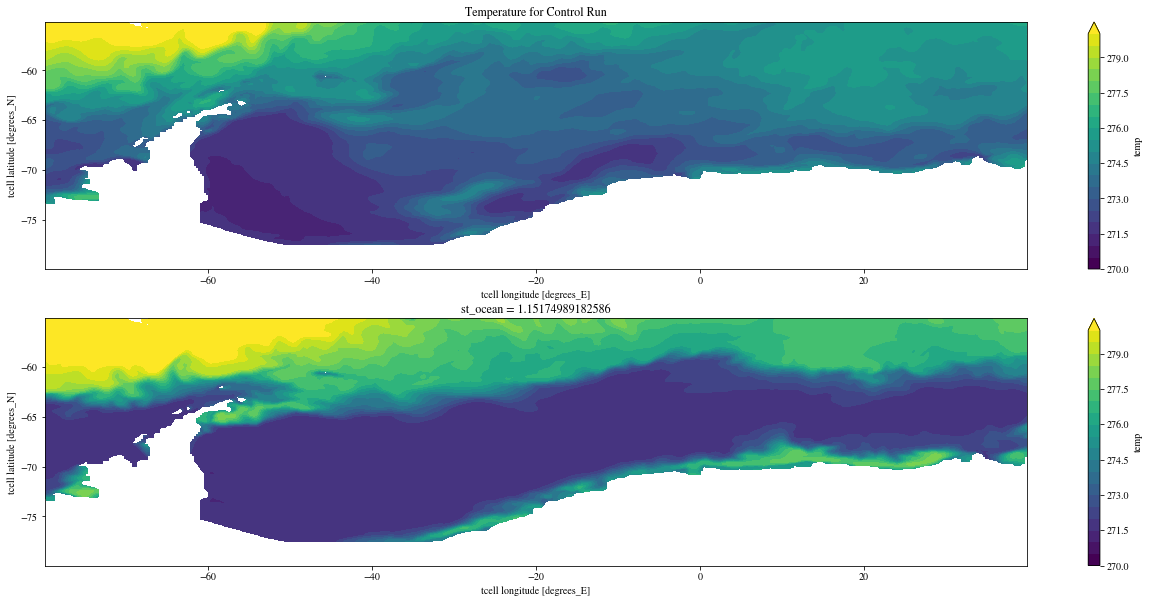

In [12]:
plt.figure(figsize=(22,10))

plt.subplot(211)
T_con.sel(time = slice('1905-01-01','1905-01-31')).sel(st_ocean = 1, method = 'nearest').mean('time').plot.contourf(levels = np.linspace(270,280,21))
plt.title('Temperature for Control Run')

plt.subplot(212)
T_buo.sel(time = slice('1905-01-01','1905-01-31')).sel(st_ocean = 1, method = 'nearest').mean('time').plot.contourf(levels = np.linspace(270,280,21))
plt.title('Temperature for No-Stress Run')
plt.show()

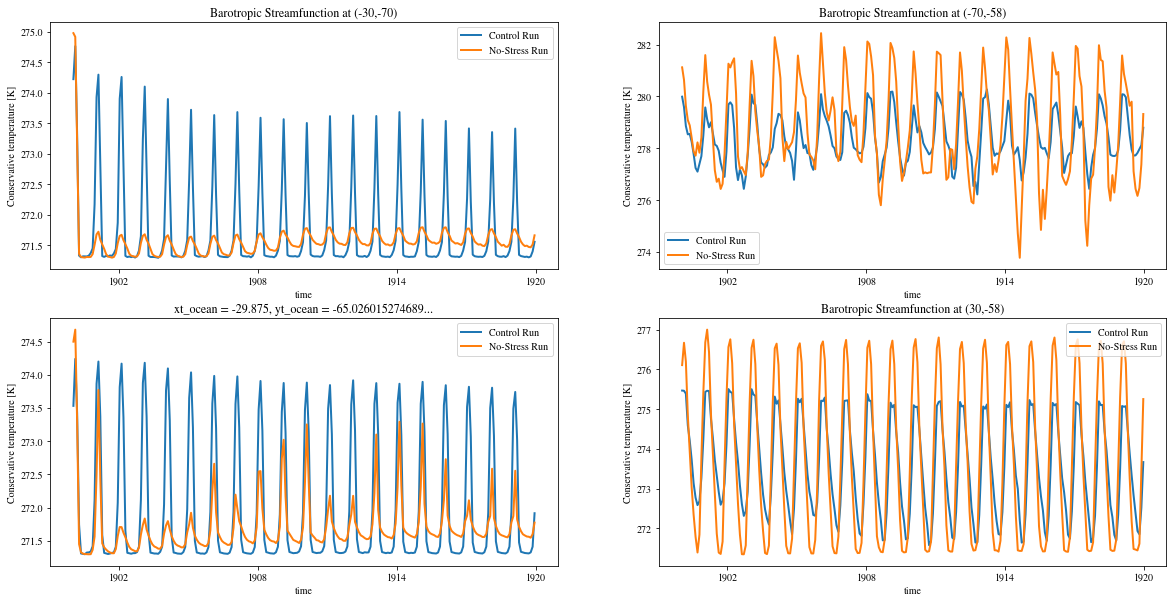

In [16]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,10))

T_con.sel(xt_ocean = -30, method = 'nearest').sel(yt_ocean = -68, method = 'nearest').sel(st_ocean = 1, method = 'nearest').plot(ax=axes[0][0],label='Control Run')
T_buo.sel(xt_ocean = -30, method = 'nearest').sel(yt_ocean = -68, method = 'nearest').sel(st_ocean = 1, method = 'nearest').plot(ax=axes[0][0],label='No-Stress Run')

T_con.sel(xt_ocean = -30, method = 'nearest').sel(yt_ocean = -65, method = 'nearest').sel(st_ocean = 1, method = 'nearest').plot(ax=axes[1][0],label='Control Run')
T_buo.sel(xt_ocean = -30, method = 'nearest').sel(yt_ocean = -65, method = 'nearest').sel(st_ocean = 1, method = 'nearest').plot(ax=axes[1][0],label='No-Stress Run')

T_con.sel(xt_ocean = -70, method = 'nearest').sel(yt_ocean = -58, method = 'nearest').sel(st_ocean = 1, method = 'nearest').plot(ax=axes[0][1],label='Control Run')
T_buo.sel(xt_ocean = -70, method = 'nearest').sel(yt_ocean = -58, method = 'nearest').sel(st_ocean = 1, method = 'nearest').plot(ax=axes[0][1],label='No-Stress Run')

T_con.sel(xt_ocean = 30, method = 'nearest').sel(yt_ocean = -58, method = 'nearest').sel(st_ocean = 1, method = 'nearest').plot(ax=axes[1][1],label='Control Run')
T_buo.sel(xt_ocean = 30, method = 'nearest').sel(yt_ocean = -58, method = 'nearest').sel(st_ocean = 1, method = 'nearest').plot(ax=axes[1][1],label='No-Stress Run')

axes[0][0].set_title('Barotropic Streamfunction at (-30,-70)')
axes[0][1].set_title('Barotropic Streamfunction at (-70,-58)')
axes[1][1].set_title('Barotropic Streamfunction at (30,-58)')

axes[0][0].legend()
axes[0][1].legend()
axes[1][0].legend()
axes[1][1].legend()